# Check Complexity Measures for Correlation

In [36]:
# get data dictionary
from utils import constants, helpers
import assess_datasets

data_dictionary = helpers.load_data_dictionary(constants.DATA_DICTIONARY_FILE_PATH)


In [37]:
import random
import numpy as np
from typing import List, Tuple, Optional

def sample_random_trace_sets_no_replacement(
    event_log,
    min_size: int = 10,
    max_size: int = 500,       
    num_sizes: int = 10, 
    samples_per_size: int = 10,
    spacing: str = "linear",              # "linear" or "log"
    random_state: Optional[int] = None
) -> List[Tuple[int, int, list]]:
    """
    Create random, non-consecutive trace sets without replacement,
    automatically choosing sizes based on log length, min_size, and max_size.

    Returns: list of tuples (window_size, sample_id, trace_list)
    """
    if random_state is not None:
        random.seed(random_state)
        np.random.seed(random_state)

    n_traces = len(event_log)
    if n_traces < min_size:
        return []

    # Apply user-defined max_size cap
    if max_size is not None:
        max_size = min(max_size, n_traces)
    else:
        max_size = n_traces

    # Budget = how many traces we can "spend" per repetition
    budget = n_traces // samples_per_size
    if budget < min_size:
        return []

    # The largest feasible size under budget and max_size
    feasible_max_size = min(max_size, budget)

    # --- Generate size list ---
    if spacing.lower() == "linear":
        if num_sizes <= 1 or feasible_max_size <= min_size:
            sizes = np.array([min_size] * max(1, num_sizes), dtype=int)
        else:
            sizes = np.linspace(min_size, feasible_max_size, num_sizes).astype(int)
    else:  # "log" spacing
        if num_sizes <= 1 or feasible_max_size <= min_size:
            sizes = np.array([min_size] * max(1, num_sizes), dtype=int)
        else:
            sizes = np.geomspace(min_size, feasible_max_size, num_sizes).astype(int)

    # Ensure monotonic increase and cap at feasible_max_size
    sizes = np.clip(sizes, min_size, feasible_max_size)
    sizes = np.maximum.accumulate(sizes)

    # Safety: shrink sizes from the end if total budget exceeded
    while sizes.sum() > budget and sizes[-1] > min_size:
        sizes[-1] -= 1

    # --- Sampling without replacement ---
    available = list(range(n_traces))
    results: List[Tuple[int, int, list]] = []

    for sample_id in range(samples_per_size):
        for size in sizes:
            if len(available) < size:
                break
            idxs = random.sample(available, int(size))
            for idx in idxs:
                available.remove(idx)
            chosen_traces = [event_log[i] for i in idxs]
            results.append((int(size), int(sample_id), chosen_traces))

        if len(available) < min_size:
            break

    return results


In [38]:
from pathlib import Path
import random
import pandas as pd
from pm4py.objects.log.importer.xes import importer as xes_importer
import numpy as np


measures_per_sample_per_dataset = {}
for dataset, dataset_info in data_dictionary.items():
    print(f"Processing {dataset}")
    # load the log
    log_path = Path(dataset_info["path"])
    pm4py_log = xes_importer.apply(str(log_path))

    sample_sizes = range(100, 1001, 100)
    samples_per_size = 10

    samples = sample_random_trace_sets_no_replacement(
        pm4py_log,
        random_state=0
    )

    # compute complexity for each sample
    measures_per_sample = []  # rows

    for size, sample_id, traces in samples:
        measures = assess_datasets.get_measures_for_traces(traces)
        measures_per_sample.append({
            **measures,
            "window_size": size,
            "sample_id": sample_id
        })

    df = pd.DataFrame(measures_per_sample)
    measures_per_sample_per_dataset[dataset] = df

Processing ACCRE


parsing log, completed traces :: 100%|██████████| 398/398 [00:00<00:00, 4910.02it/s]

Processing BPIC12



parsing log, completed traces :: 100%|██████████| 13087/13087 [00:09<00:00, 1413.78it/s]


Processing BPIC13_cp


parsing log, completed traces :: 100%|██████████| 1487/1487 [00:00<00:00, 3770.68it/s]


Processing BPIC13_i


parsing log, completed traces :: 100%|██████████| 7554/7554 [00:04<00:00, 1826.51it/s]


Processing BPIC14


parsing log, completed traces :: 100%|██████████| 46616/46616 [00:29<00:00, 1576.28it/s]


Processing BPIC15_1


parsing log, completed traces :: 100%|██████████| 1199/1199 [00:03<00:00, 397.16it/s]


Processing BPIC15_2


parsing log, completed traces :: 100%|██████████| 832/832 [00:02<00:00, 334.29it/s]


Processing BPIC15_3


parsing log, completed traces :: 100%|██████████| 1409/1409 [00:03<00:00, 366.52it/s]


Processing BPIC15_4


parsing log, completed traces :: 100%|██████████| 1053/1053 [00:02<00:00, 379.40it/s]


Processing BPIC15_5


parsing log, completed traces :: 100%|██████████| 1156/1156 [00:04<00:00, 279.22it/s]


Processing BPIC17


parsing log, completed traces :: 100%|██████████| 31509/31509 [00:44<00:00, 715.57it/s]


Processing BPIC18


parsing log, completed traces :: 100%|██████████| 43809/43809 [02:23<00:00, 305.68it/s]


Processing BPIC19


parsing log, completed traces :: 100%|██████████| 251734/251734 [00:55<00:00, 4552.94it/s]


Processing BPIC20_dd


parsing log, completed traces :: 100%|██████████| 10500/10500 [00:01<00:00, 6227.19it/s]


Processing BPIC20_id


parsing log, completed traces :: 100%|██████████| 6449/6449 [00:04<00:00, 1540.83it/s]


Processing BPIC20_ptc


parsing log, completed traces :: 100%|██████████| 2099/2099 [00:00<00:00, 3272.59it/s]


Processing BPIC20_rfp


parsing log, completed traces :: 100%|██████████| 6886/6886 [00:01<00:00, 6046.52it/s]


Processing BPIC20_tpd


parsing log, completed traces :: 100%|██████████| 7065/7065 [00:02<00:00, 2513.60it/s]


Processing CALL


parsing log, completed traces :: 100%|██████████| 260889/260889 [00:26<00:00, 9867.64it/s] 


Processing ITHD


parsing log, completed traces :: 100%|██████████| 4580/4580 [00:01<00:00, 2310.16it/s]


Processing RTFMP


parsing log, completed traces :: 100%|██████████| 150370/150370 [00:16<00:00, 8867.22it/s] 


Processing SEPSIS


parsing log, completed traces :: 100%|██████████| 1050/1050 [00:00<00:00, 1400.52it/s]


In [39]:
measures_per_sample_per_dataset['ACCRE']

,Magnitude,Support,Variety,Level of detail,Time granularity,Structure,Affinity,Distinct traces,Deviation from random,Lempel-Ziv complexity,...,Pentland's process complexity,Variant Entropy,Normalized Variant Entropy,Trace Entropy,Normalized Trace Entropy,Trace length min,Trace length avg,Trace length max,window_size,sample_id
0,45,10,10,4.500000,1.600000,0.850000,0.446481,50.000000,0.622306,22,...,3.019952,26.297473,0.505461,46.376483,0.270733,3,4.500000,7,10,0
1,68,13,11,5.230769,2.307692,0.867769,0.362351,46.153846,0.682989,32,...,3.019952,39.493439,0.490773,89.843779,0.313125,3,5.230769,8,13,0
2,78,16,12,4.875000,3.312500,0.854167,0.384427,50.000000,0.662712,37,...,6.309573,51.869243,0.555930,103.544777,0.304702,3,4.875000,9,16,0
3,89,19,12,4.684211,1.789474,0.861111,0.396660,47.368421,0.645446,37,...,5.248075,52.487028,0.514398,111.899725,0.280107,3,4.684211,10,19,0
4,94,22,9,4.272727,2.818182,0.814815,0.430011,31.818182,0.615601,37,...,3.630781,34.541114,0.540254,98.197798,0.229934,3,4.272727,7,22,0
5,122,26,15,4.692308,2.480000,0.884444,0.313570,50.000000,0.663905,51,...,9.120108,79.923028,0.619526,172.593658,0.294483,1,4.692308,10,26,0
6,144,29,12,4.965517,1.965517,0.875000,0.352674,37.931034,0.669204,58,...,3.630781,44.411650,0.524276,160.625336,0.224446,3,4.965517,9,29,0
7,149,32,12,4.625000,1.906250,0.826389,0.343215,43.750000,0.655996,59,...,13.182567,84.830989,0.634944,215.298616,0.288764,3,4.656250,8,32,0
8,186,35,14,5.028571,2.285714,0.867347,0.350892,40.000000,0.690036,75,...,10.964782,104.082317,0.532115,300.324777,0.308980,3,5.314286,16,35,0
9,48,10,12,4.800000,2.666667,0.868056,0.202751,80.000000,0.693139,27,...,4.365158,44.940391,0.558461,75.732636,0.407564,1,4.800000,8,10,0


In [40]:
import numpy as np
from scipy.stats import pearsonr

correlation_results = {}
for dataset, df in measures_per_sample_per_dataset.items():
    if "window_size" not in df.columns:
        raise KeyError(f"'window_size' missing for dataset {dataset}")

    # choose numeric measure columns, exclude identifiers
    measure_cols = [
        c for c in df.columns
        if c not in ["window_size", "sample_id"]
        and pd.api.types.is_numeric_dtype(df[c])
    ]

    ws = pd.to_numeric(df["window_size"], errors="coerce")
    rows = []
    for col in measure_cols:
        x = pd.to_numeric(df[col], errors="coerce")
        pair = (pd.DataFrame({"x": x, "y": ws})
                .replace([np.inf, -np.inf], np.nan)
                .dropna())
        if len(pair) < 2 or pair["x"].nunique() < 2 or pair["y"].nunique() < 2:
            r, p = np.nan, np.nan
        else:
            r, p = pearsonr(pair["x"].to_numpy(), pair["y"].to_numpy())
        rows.append({"measure": col, "n": len(pair), "pearson_r": r, "p_value": p})

    correlation_results[dataset] = (pd.DataFrame(rows)
                                    .sort_values("measure")
                                    .reset_index(drop=True))


In [41]:
correlation_results['BPIC14']

,measure,n,pearson_r,p_value
0,Affinity,100,-0.100784,3.184179e-01
1,Deviation from random,100,0.500668,1.128660e-07
2,Distinct traces,100,-0.882449,7.257255e-34
3,Lempel-Ziv complexity,100,0.994010,4.866029e-96
4,Level of detail,100,0.046226,6.478951e-01
5,Magnitude,100,0.994411,1.655585e-97
6,Normalized Trace Entropy,100,0.710828,1.183221e-16
7,Normalized Variant Entropy,100,0.760248,4.598888e-20
8,Pentland's process complexity,100,0.215416,3.136469e-02
9,Pentland's task complexity,100,0.991426,1.968351e-88


In [42]:
import pandas as pd

# correlation_results[dataset] = DataFrame with columns: measure, n, pearson_r, p_value
# and one row per measure

# First, reindex each DF by measure and make a MultiIndex column
df_list = []
for dataset, df in correlation_results.items():
    df = df.set_index("measure")[["n", "pearson_r", "p_value"]]
    # Add dataset name as first level of column MultiIndex
    df.columns = pd.MultiIndex.from_product([[dataset], df.columns])
    df_list.append(df)

# Join on the measure index
combined_df = pd.concat(df_list, axis=1)

# Optional: sort measures alphabetically
combined_df = combined_df.sort_index()

print(combined_df)


                              ACCRE                         BPIC12            \
                                  n pearson_r       p_value      n pearson_r   
measure                                                                        
Affinity                         19  0.305770  2.029843e-01     70 -0.125034   
Deviation from random            19 -0.282687  2.409308e-01     70  0.227764   
Distinct traces                  19 -0.656177  2.280538e-03     70 -0.623829   
Lempel-Ziv complexity            19  0.944234  1.261845e-09     70  0.992645   
Level of detail                  19 -0.317074  1.859337e-01     70  0.074969   
Magnitude                        19  0.979630  2.727139e-13     70  0.995080   
Normalized Trace Entropy         19 -0.494074  3.154559e-02     70  0.693958   
Normalized Variant Entropy       19  0.402978  8.713531e-02     70  0.816909   
Pentland's process complexity    19 -0.214283  3.783594e-01     70  0.703042   
Pentland's task complexity       19  0.6

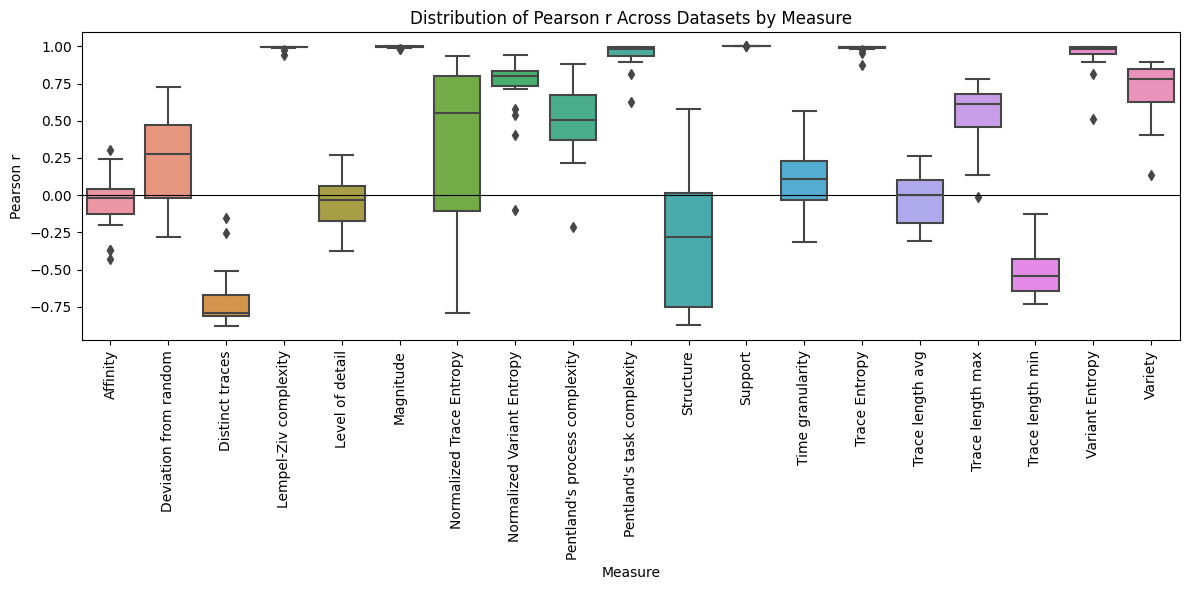

In [44]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Flatten correlation_results into one long DataFrame
all_corrs = []
for dataset, df in correlation_results.items():
    for _, row in df.iterrows():
        all_corrs.append({
            "dataset": dataset,
            "measure": row["measure"],
            "pearson_r": row["pearson_r"]
        })

corr_df = pd.DataFrame(all_corrs)

# Sort measures for consistent x-axis order
order = sorted(corr_df["measure"].unique())

# Create Seaborn boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=corr_df,
    x="measure",
    y="pearson_r",
    order=order
)

# Formatting
plt.axhline(0, color="black", linewidth=0.8)
plt.xticks(rotation=90)
plt.ylabel("Pearson r")
plt.xlabel("Measure")
plt.title("Distribution of Pearson r Across Datasets by Measure")
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np

summary_rows = []

for measure in sorted({row["measure"] for df in correlation_results.values() for _, row in df.iterrows()}):
    r_values = []
    p_values = []
    sig_count = 0
    total_count = 0
    
    for dataset, df in correlation_results.items():
        row = df[df["measure"] == measure]
        if not row.empty:
            r = row["pearson_r"].values[0]
            p = row["p_value"].values[0]
            if pd.notna(r) and pd.notna(p):
                r_values.append(abs(r))
                p_values.append(p)
                total_count += 1
                if p <= 0.05:
                    sig_count += 1
    
    if total_count > 0:
        summary_rows.append({
            "measure": measure,
            "median_abs_r": np.median(r_values),
            "median_p_value": np.median(p_values),
            "pct_significant_(p<0.05)": (sig_count / total_count) * 100,
            "n_datasets": total_count
        })

summary_df = pd.DataFrame(summary_rows).sort_values("median_abs_r").reset_index(drop=True)
summary_df

,measure,median_abs_r,median_p_value,pct_significant_(p<0.05),n_datasets
0,Affinity,0.084759,5.581974e-01,4.545455,22
1,Level of detail,0.139476,4.396348e-01,0.000000,22
2,Trace length avg,0.141328,3.281511e-01,0.000000,22
3,Time granularity,0.181452,2.783148e-01,19.047619,21
4,Deviation from random,0.291407,5.911145e-02,45.454545,22
5,Structure,0.394507,2.894487e-02,59.090909,22
6,Pentland's process complexity,0.503269,4.560839e-04,68.181818,22
7,Trace length min,0.541663,1.219412e-04,84.210526,19
8,Trace length max,0.614321,6.702587e-06,90.909091,22
9,Normalized Trace Entropy,0.679121,5.051271e-07,77.272727,22
